In [223]:
import pandas as pd
import datetime
import math
from sklearn.metrics import mean_squared_error,r2_score

In [171]:
from understanding_data import seller_monthly_transaction_count_line_graph
from understanding_data import seller_biweekly_transaction_count_line_graph

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [141]:
def getInformation(s_id):
    sellerdf, unique_prod_categories = getData(s_id)
    print('Unique Product Categories Sold by Seller:', unique_prod_categories)
    startdate = sellerdf['order_purchase_timestamp'].min()
    enddate = sellerdf['order_purchase_timestamp'].max()
    print('Earliest Sale Date:', startdate)
    print('Last Sale Date:',enddate)
    print('\n Basic Information on sales by seller:\n')
    dataseller = sellerdf['product_category_name_english'].value_counts()
    dataseller_df = pd.DataFrame(data=dataseller)
    dataseller_df.rename(columns={'product_category_name_english':'sales per product category'},inplace=True)
    print(dataseller_df)

def getDashboard(s_id):
    sellerdf, unique_prod_categories = getData(s_id)
    prod_select = input('Enter Product Category:')
    print('Monthly Sales of Category:',prod_select)
    seller_monthly_transaction_count_line_graph(s_id, prod_select)
    print('Bi Weekly Sales of Product Category:', prod_select)
    seller_biweekly_transaction_count_line_graph(s_id, prod_select)

def getData(s_id):
    data_new = pd.read_csv('../Data/Primary_Secondary.csv')
    data_new = data_new.drop(columns = ['Unnamed: 0'])
    data_new['order_purchase_timestamp'] = pd.to_datetime(data_new['order_purchase_timestamp'])
    new_data = data_new[data_new.seller_id==s_id]
    new_data = new_data.sort_values(by='order_purchase_timestamp')
    new_data = new_data.drop(['order_id', 'customer_id', 'order_status',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'shipping_limit_date',
       'seller_zip_code_prefix', 'seller_city','product_id',
       'seller_state', 'product_name_lenght', 'product_description_lenght',
       'customer_unique_id','Bi-Weekly','datediff_purchase_deliver'],axis=1)
    unique = new_data['product_category_name_english'].unique()
    return new_data, unique

In [306]:
def Gradient_Boosting_Model(seller_id):
    model_data,unique_names = getData(seller_id)
    
    category = input('Enter Product Category you want to analyze:')
    model_data = model_data[model_data['product_category_name_english']==category]
    
    if model_data.shape[0] < 0:
        print("Not enogh data to fit model")
        return
    
    #Extract date from order_purchase_timestamp
    model_data['order_purchase_timestamp'] = model_data['order_purchase_timestamp'].apply(lambda x: x.date()).astype('str')
    model_data = model_data.drop(['seller_id','product_category_name_english','customer_city','customer_state'],axis=1)
    
    print(model_data.shape)
    ## Count the number sales on each day
    seller_count = model_data.groupby(['order_purchase_timestamp']).size().reset_index(name='count')
    model_data = pd.merge(model_data, seller_count, how='inner',left_on=['order_purchase_timestamp'],right_on=['order_purchase_timestamp'])
    model_data = model_data.drop_duplicates(keep='first',subset = 'order_purchase_timestamp')
    print(seller_count.shape)
    ## Perform train test split. We are taking last 30 days from data for testing. Remaining is used for training
    length = model_data.shape[0]
    num_rows_split = length - 30 
    model_data = model_data.drop(['order_purchase_timestamp','transaction_year','transaction_date','customer_zip_code_prefix','price','freight_value'],axis = 1)
    ## Covert transaction_month 
    model_data['transaction_month'] = model_data['transaction_month'].astype('category')
    model_train = model_data[:num_rows_split]
    model_test = model_data[num_rows_split:]
    
    x_train = model_train.drop(columns = 'count',axis = 1)
    y_train = model_train['count']

    x_test = model_test.drop(columns = 'count',axis = 1)
    y_test = model_test['count']

    learning_rate = [0.01,0.03,0.05,0.07,0.09]
    min_samples_split = [2,3,4]
    min_samples_leaf = [1,2]
    max_depth = [2,3,4]
    
    ## For hyper parameter tuning
    mse_min = 9999
    lr_min = 0.01
    min_samples_split_min = 2
    min_samples_leaf_min = 1
    max_depth_min = 2
    for lr in learning_rate:
        for mss in min_samples_split:
            for msl in min_samples_leaf:
                for md in max_depth:
                    params = {'min_samples_split':2,'learning_rate': 0.01, 'verbose':0,'max_depth':2,'min_samples_leaf':1}
                    clf = ensemble.GradientBoostingRegressor(**params)
                    clf.fit(x_train, y_train)
                    mse = mean_squared_error(y_test, clf.predict(x_test))
                    
                    if mse < mse_min:
                        mse_min = mse 
                        lr_min = lr
                        min_samples_split_min = mss
                        min_samples_leaf_min = msl
                        max_depth_min = md
                        
    print("Best MSE is ",mse_min,"for ",lr_min,min_samples_split_min,min_samples_leaf_min,max_depth_min)
    params = {'min_samples_split':min_samples_split_min,'learning_rate': lr_min, 'verbose':0,'max_depth':max_depth_min,'min_samples_leaf':min_samples_leaf_min}
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(x_train, y_train)
    

    test_score = np.zeros((100,), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(x_test)):
        test_score[i] = clf.loss_(y_test, y_pred)

    ## Plotting training and testing deviance
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(100) + 1, clf.train_score_, 'b-',label='Training Set Deviance')
    plt.plot(np.arange(100) + 1, test_score, 'r-',label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    plt.show()
    y_pred1 = clf.staged_predict(x_train)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    fig = plt.gcf()
    fig.set_size_inches(12.5,8.5)
    plt.plot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, x_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    fiveday_actual = []
    fiveday_pred = []
    for i in range(6):
        fiveday_actual.append(math.ceil(sum(y_test[5*i:5*i+5])))
        fiveday_pred.append(math.ceil(sum(clf.predict(x_test)[5*i:5*i+5])))
    
    agg_pred = math.ceil(sum(clf.predict(x_test)))
    agg_actual = math.ceil(sum(y_test))
    print("Actual count",agg_actual)
    print("Predicted count",agg_pred)
    
    plt.plot(fiveday_actual)
    plt.plot(fiveday_pred,'r')
    plt.show()

Enter Product Category you want to analyze:watches_gifts
(1600, 35)
(463, 2)
Best MSE is  16.905508343668046 for  0.01 2 1 2


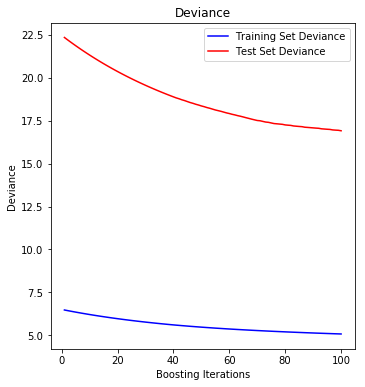

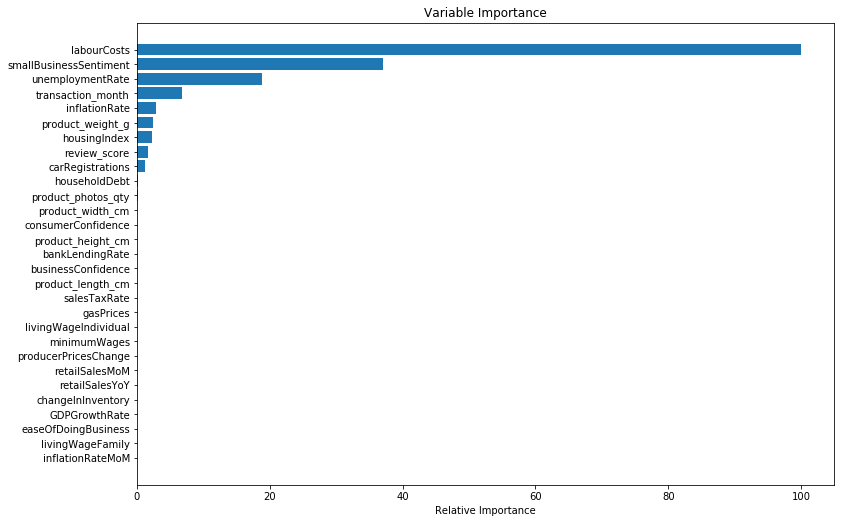

Actual count 182
Predicted count 138


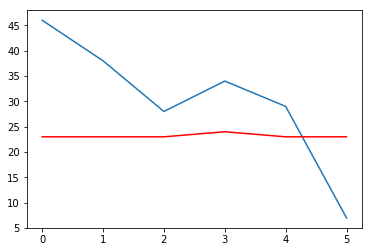

In [308]:
model_data = Gradient_Boosting_Model('6560211a19b47992c3666cc44a7e94c0')

In [173]:
from fbprophet import Prophet

In [276]:
def prophet_model(seller_id):
    model_data,unique_names = getData(seller_id)
    
    category = input('Enter Product Category you want to analyze:')
    model_data = model_data[model_data['product_category_name_english']==category]
    
    if model_data.shape[0]<300:
        print("Not enough data to fit the model")
    ## Extract date from order_purchase_timestamp
    model_data['order_purchase_timestamp'] = model_data['order_purchase_timestamp'].apply(lambda x: x.date()).astype('str')
    model_data['order_purchase_timestamp'] = pd.to_datetime(model_data['order_purchase_timestamp'])
    
    seller_count = model_data.groupby(['order_purchase_timestamp']).size().reset_index(name='count')
    seller_price = model_data.groupby(['order_purchase_timestamp'])['price'].mean()
    seller_count = pd.merge(seller_count,seller_price,how = 'inner', left_on =['order_purchase_timestamp'],right_on = ['order_purchase_timestamp'])
    #print(seller_count)
    
    model_data = pd.merge(model_data, seller_count, how='inner',left_on=['order_purchase_timestamp'],right_on=['order_purchase_timestamp'],copy=False)

    model_data = model_data.drop_duplicates(keep='first',subset = 'order_purchase_timestamp')
    print(model_data.columns)
    model_data['revenue'] = model_data['count']*model_data['price_y']
    print("Mean = ", model_data['price_x'].mean())
    seller = model_data[['order_purchase_timestamp','count']]
    seller.columns  = ['ds','y']
    
    
    ## Split into train and test based on last 30
    number_of_obs = seller.shape[0]
    split = 30
    #print(test_split)
    #print(test_split.value_counts())
    print("split = ",split)
    train = seller[:-split]
    test = seller[-split:]
    
    end = test['ds'].iloc[-1]
    start = test['ds'].iloc[0]
    diff = end -start
    
    ## Add holidays of interest for better prediction during this time
    holidays = pd.DataFrame({'holiday': 'days_of_interest','ds': pd.to_datetime(['2017-01-01','2017-02-27','2017-02-28',
    '2017-03-01','2017-04-14','2017-04-21','2017-05-01','2017-05-15','2017-07-09','2017-09-07','2017-10-12','2017-10-27',
    '2017-11-01','2017-11-02','2017-11-15','2017-11-20','2017-12-25','2018-01-01','2018-02-27','2018-02-28',
    '2018-03-01','2018-04-14','2018-04-21','2018-05-01','2018-05-15','2018-07-09']),
  'lower_window': -1,
  'upper_window': 1,
})
    prophet_model = Prophet(changepoint_prior_scale=0.8,yearly_seasonality=True,holidays=holidays)
    
    prophet_model.fit(train)
    
    
    ## set the extended periods as present in the test data
    #predict = prophet_model.make_future_dataframe(periods=diff.days)
    #print("Diff days = ",diff.days)
    #print(test['ds'])
    forecast = prophet_model.predict(pd.DataFrame(test['ds']))
    forecast_tail = forecast[['ds','yhat','yhat_lower','yhat_upper']]
    print(test.shape,forecast_tail.shape)
    #test['yhat'] = forecast_tail['yhat']
    
    mse = mean_squared_error(test['y'],forecast_tail['yhat'])
    #r_score = r2_score(test['y'],forecast_tail['yhat'])
    
    ## plot the prophet forecasts
    fig1 = prophet_model.plot(forecast)
    
    fig2 = prophet_model.plot_components(forecast)
    
    ## Count extra number of days in training 
    diff_train = (train['ds'].iloc[-1] - train['ds'].iloc[0]).days
    #print(diff_train, train.shape[0])
    extra_days_test = math.floor(((diff_train-train.shape[0])/diff_train)*diff.days)
    #print("Extra days in test:",extra_days_test)
    ## Predicted Count on the test
    predicted_count  = np.ceil(np.sum(forecast_tail[-diff.days:]['yhat']))
    
    ## Average number of sales predicted per day
    average = math.floor(train['y'].median())
    
    
    ## Remove the extra count values coming from extra days
   # predicted_count = predicted_count - extra_days_test*average
    
    ## Actual count of the test set
    actual_count = np.sum(test['y'])
    
    print("Predicted count = ",predicted_count)
    print("Average Sales = ",average)
    print("Actual count = ",actual_count)
    print("Mean Squared for this model is", mse)

Enter Product Category you want to analyze:watches_gifts


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['order_purchase_timestamp', 'seller_id', 'price_x', 'freight_value',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_score', 'transaction_year',
       'transaction_month', 'transaction_date', 'bankLendingRate',
       'businessConfidence', 'carRegistrations', 'consumerConfidence',
       'gasPrices', 'housingIndex', 'inflationRate', 'inflationRateMoM',
       'labourCosts', 'minimumWages', 'producerPricesChange', 'retailSalesMoM',
       'retailSalesYoY', 'smallBusinessSentiment', 'unemploymentRate',
       'changeInInventory', 'GDPGrowthRate', 'householdDebt',
       'easeOfDoingBusiness', 'livingWageFamily', 'livingWageIndividual',
       'salesTaxRate', 'count', 'price_y'],
      dtype='object')
Mean =  62.01079913606912
split =  30
(30, 2) (30, 4)
Predicted count =  203.0
Average Sales =  

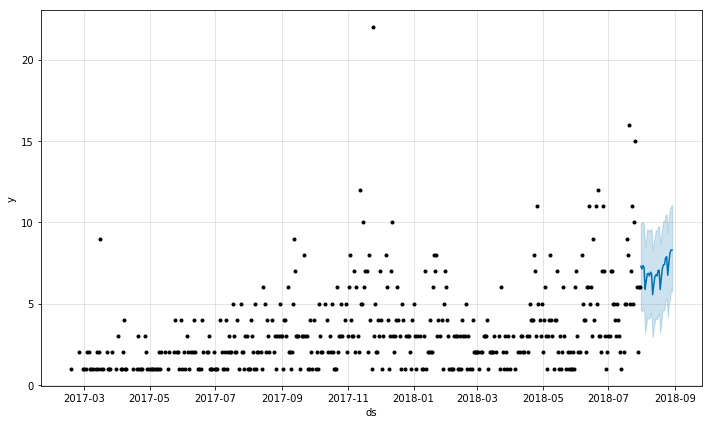

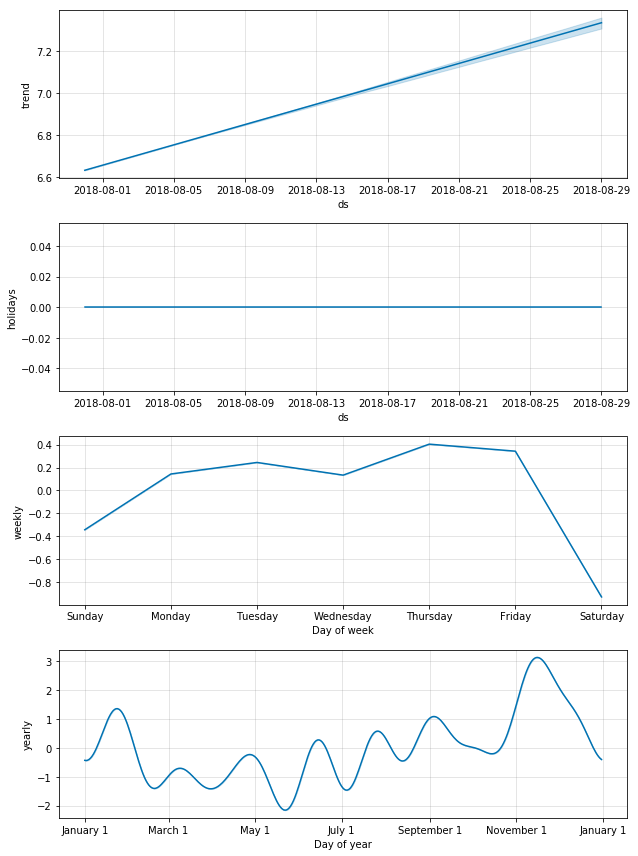

In [277]:
prophet_model('6560211a19b47992c3666cc44a7e94c0')

In [48]:
import matplotlib.dates as mdates

In [57]:
def arima_model(seller_id):
    model_data,unique_names = getData(seller_id)
    
    category = input('Enter Product Category you want to analyze:')
    model_data = model_data[model_data['product_category_name_english']==category]
    
    print(model_data['product_id'].value_counts())
    product_id = input('Enter Product Id you want to analyze:')
    model_data = model_data[model_data['product_id']==product_id]
    
    getInformation(seller_id)
    
    ## Extract date from order_purchase_timestamp
    model_data['order_purchase_timestamp'] = model_data['order_purchase_timestamp'].apply(lambda x: x.date()).astype('str')
    model_data['order_purchase_timestamp'] = pd.to_datetime(model_data['order_purchase_timestamp'])
    
    ## Extract year and month from "order_purchase_timestamp"
    model_data['year'] = pd.DatetimeIndex(model_data['order_purchase_timestamp']).year
    model_data['month'] = pd.DatetimeIndex(model_data['order_purchase_timestamp']).month
    
    seller_count = model_data.groupby(['year','month']).size().reset_index(name='count')
    seller_count['monthly'] = seller_count['year'].astype(str) + '-' + seller_count['month'].astype(str) + '-01'
    #seller_count['monthly'] = mdates.date2num(seller_count.monthly.to_pydatetime())
    seller_count['monthly'] = pd.to_datetime(seller_count['monthly'],infer_datetime_format=True)
    
    seller_count = seller_count[['monthly','count']]
    return seller_count

In [59]:
seller = arima_model('955fee9216a65b617aa5c0531780ce60')

Enter Product Category you want to analyze:furniture_decor
aca2eb7d00ea1a7b8ebd4e68314663af    520
59b47581b7ba51a62bf9c3dd4fef36fd      8
Name: product_id, dtype: int64
Enter Product Id you want to analyze:aca2eb7d00ea1a7b8ebd4e68314663af
Unique Product Categories Sold by Seller: ['housewares' 'computers_accessories' 'furniture_decor' 'sports_leisure'
 'health_beauty' 'fixed_telephony' 'cool_stuff' 'garden_tools' 'telephony'
 'stationery' 'small_appliances' 'kitchen_dining_laundry_garden_furniture'
 'auto' 'musical_instruments' 'construction_tools_lights'
 'office_furniture' 'agro_industry_and_commerce' 'art' 'toys'
 'costruction_tools_tools' 'industry_commerce_and_business'
 'construction_tools_construction' 'food']
Earliest Sale Date: 2017-07-24 11:33:00
Last Sale Date: 2018-08-28 20:49:00

 Basic Information on sales by seller:

                                         sales per product category
furniture_decor                                                 528
housewares         

In [72]:
sales = seller

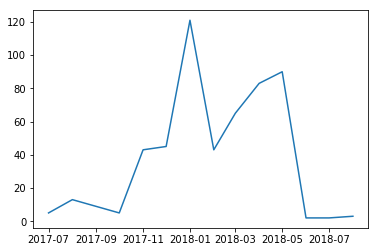

In [73]:
plt.plot(sales['monthly'],sales['count'])

In [124]:
sales

,monthly,count
0,2017-07-01,5
1,2017-08-01,13
2,2017-10-01,5
3,2017-11-01,43
4,2017-12-01,45
5,2018-01-01,121
6,2018-02-01,43
7,2018-03-01,65
8,2018-04-01,83
9,2018-05-01,90


In [75]:
diff = sales.diff(periods=1)

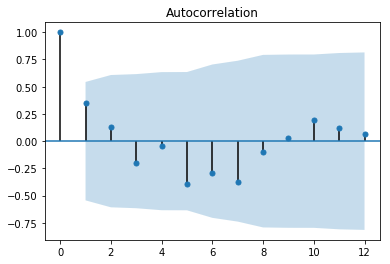

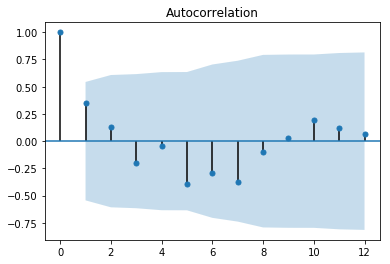

In [76]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sales['count'])

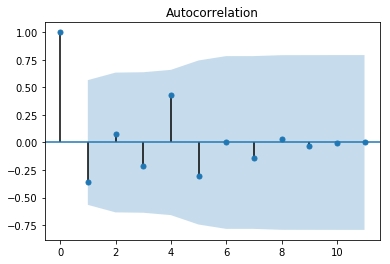

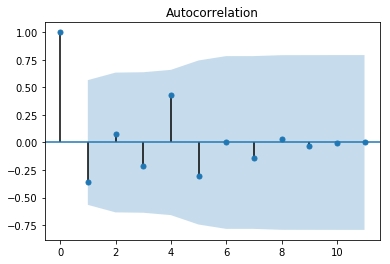

In [77]:

diff = diff[1:]
plot_acf(diff['count'])

In [85]:
X = sales['count']
X

0       5
1      13
2       5
3      43
4      45
5     121
6      43
7      65
8      83
9      90
10      2
11      2
12      3
Name: count, dtype: int64

In [100]:
train = X[:10]
test = X[10:]
predictions = []
test.size

3

In [101]:
from statsmodels.tsa.arima_model import ARIMA

In [121]:
model = ARIMA(train, order=(5,2,1))

In [122]:
model_fit = model.fit()

In [123]:
predictions = model_fit.forecast(steps=3)[0]
predictions

array([92.43922742,  4.45659723, 68.09532194])

In [119]:
import itertools
p=d=q=range(0,7)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 5),
 (0, 4, 6),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 5),
 (0, 5, 6),
 (0, 6, 0),
 (0, 6, 1),
 (0, 6, 2),
 (0, 6, 3),
 (0, 6, 4),
 (0, 6, 5),
 (0, 6, 6),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 0, 6),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (1, 4, 5),
 (1,

In [120]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model = ARIMA(train,order=param)
        model_fit = model.fit()
        print(param,model_fit.aic)
    except:
        continue

(0, 0, 0) 104.44261776251709
(0, 0, 1) 105.58355810631643
(0, 0, 2) 106.43770226698585
(0, 0, 3) 108.42862755181942
(0, 0, 4) 109.87750820680947
(0, 1, 0) 95.3533562012221
(0, 1, 1) 91.44746674033615
(0, 2, 0) 95.41854593876553
(0, 2, 1) 90.3281873412985
(1, 0, 0) 104.97865205338303
(1, 0, 1) 108.44261692046533
(1, 0, 2) 119.14263036891919
(1, 1, 0) 93.82017888383912
(1, 1, 2) 95.4474668495762
(1, 2, 0) 91.4470064542219
(1, 2, 2) 90.68809341302537
(1, 2, 3) 92.95041460521054
(1, 2, 4) 98.57284734823574
(2, 0, 0) 106.33769387582348
(2, 1, 0) 95.39035291509431
(2, 1, 2) 97.2411901294991
(2, 1, 4) 100.14784035815403
(2, 2, 0) 92.30917788102553
(2, 2, 2) 93.90713418188373
(3, 0, 0) 108.15172597691284
(3, 1, 0) 96.48561346493821
(3, 1, 1) 96.64112275335576
(3, 2, 2) 92.78331607062385
(3, 2, 3) 96.61594888030005
(4, 0, 0) 110.14534921786473
(4, 0, 1) 116.23326466039063
(4, 1, 1) 90.60694965736621
(5, 1, 1) 92.19808488476991
(5, 1, 2) 101.06022018006846
(5, 2, 1) 83.76419200147868
(6, 0, 0) 1